# Figure 5
Expressivity of random deep vs. shallow networks


## Setup

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import os, sys
from tqdm import tqdm

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
plt.rcParams['image.cmap'] = 'viridis'

# Add cornet and Theano to path
sys.path.insert(0, '../')
sys.path.insert(0, '/home/poole/Theano_clean')

# Output figure directory
figure_dir = "../writeup/figures"
results_dir = "../results"
if not os.path.exists(figure_dir):
    raise ValueError("Figure directory does not exist. Create it or change figure_dir above.")
if not os.path.exists(results_dir):
    raise ValueError("Results directory does not exist. Create it or change results_dir above.")

Populating the interactive namespace from numpy and matplotlib


## Parameters

In [2]:
din = dout = 500 # input and output dimensionality are fixed to 500

nonlinearity = 'tanh'

# Number of input datapoints
n_interp = 10000

# Fourier basis parameters
L_over_lambda = 200

batch_size = 128

# Number of repeats for each network type
n_repeat = 5
# Widths
n_hiddens = (np.logspace(2, 4, 8)/10.).astype(int)*10
# Depths
depths = 1 + np.arange(0, 14,2)
# Indices of depths to plot
didxs = [0, 3, 6]

deep_width = 1000
shallow_depth = 1
print("Hidden layer sizes for shallow network (depth=%d): " % (shallow_depth), n_hiddens)
print("Depths for wide network (width=%d): "% deep_width , depths)

from cornet.constants import weight_sigmas, bias_sigmas, widxs, bidxs
weight_sigma = weight_sigmas[widxs][-1]
bias_sigma = bias_sigmas[bidxs][-1]

Hidden layer sizes for shallow network (depth=1):  [  100   190   370   710  1380  2680  5170 10000]
Depths for wide network (width=1000):  [ 1  3  5  7  9 11 13]


### Useful functions

In [3]:
def autocorr(x):
    x = x - x.mean()
    x /= np.linalg.norm(x)
    result = numpy.correlate(x, x, mode='full')
    return result#result[result.size/2:]

In [4]:
def generate_basis(n, L_over_lambda=2):
    xs = np.arange(n)
    omegas = 2 * np.pi * np.arange(n) / float(n)
    cutoff_freq = 2 * np.pi * L_over_lambda /float(n)
    omegas = omegas[omegas < cutoff_freq]
    nfreq = len(omegas)
    A = np.zeros((2 * nfreq, n))
    final_omegas = []
    for i, omega in enumerate(omegas):
        A[2 * i] = np.sin(omega * xs)
        A[2 * i + 1] = np.cos(omega * xs)
        final_omegas.extend([omega, omega])
    A /= np.linalg.norm(A, axis=1)[:, None]
    return final_omegas[1:], A[1:]

In [5]:
def subtract_subspace(A, B, eps=1e-9):
    B, _ = np.linalg.qr(B)
    C = (A.T - np.dot(np.dot(A.T, B), B.T)).T
    u, s, v = np.linalg.svd(C, full_matrices=False)
    nonzero_components = s > eps
    return u[:, nonzero_components]

In [6]:
def get_best_reconstruction(A, hs):
    best_residual = np.inf * np.ones(A.shape[0])
    A_net = np.zeros_like(A.T)
    for h in hs:
        out = np.linalg.lstsq(h, A.T)
        for j in xrange(A.shape[0]):
            if out[1][j] < best_residual[j]:
                best_residual[j] = out[1][j]
                A_net[:, j] = np.dot(h, out[0][:, j])
    return A_net

### Construct Fourier basis

(399, 10000)


(-0.5, 9999.5, 398.5, -0.5)

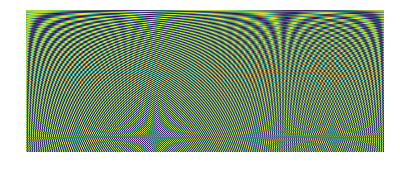

In [9]:
omegas, A = generate_basis(n_interp, L_over_lambda)
print(A.shape)
imshow(A, aspect=10); axis('off')

Input data is half of a Great Circle:

In [ ]:
from cornet.net import great_circle
ts, xs = great_circle(din, n_interp*2)
ts = ts[:n_interp]
xs = xs[:n_interp]
xs_batch = np.array_split(xs, len(xs)//batch_size)

Useful do-it-all function to pass the input data through the network, regress onto Fourier basis, and compute angular error

In [12]:
def get_angular_error(net):
    hs = np.array([np.vstack([net.get_act(xb) for xb in xs_batch])])
    hs_cache[i] = hs
    nullspace = subtract_subspace(A.T, hs.transpose(1, 0, 2).reshape(n_interp, -1))
    nullspace_cache[i] = nullspace
    out = np.linalg.lstsq(nullspace, A.T)
    A_null = np.dot(nullspace, out[0])
    A_norm = A - A.mean(1, keepdims=True)
    A_norm /= np.linalg.norm(A_norm, axis=1)[:, None]
    A_net = get_best_reconstruction(A, hs)
    A_net_cache[i] = A_net
    A_net_norm = A_net - A_net.mean(0, keepdims=True)
    A_net_norm /= np.linalg.norm(A_net, axis=0)[None, :]
    return 1 - (A_norm * A_net_norm.T).sum(-1)

### Compute errors for wide networks

In [ ]:
from cornet.net import RandNet

In [ ]:
mm_net_wide = np.zeros(( len(n_hiddens), n_repeat,  len(A)))
hs_cache = [None for i in xrange(len(n_hiddens))]
nullspace_cache = [None for i in xrange(len(n_hiddens))]
A_net_cache = [None for i in xrange(len(n_hiddens))]
for i, n_hidden_units in enumerate(tqdm(n_hiddens)):
    net = RandNet(din, n_hidden_units, 1 + shallow_depth, nonlinearity=nonlinearity, output_dim=dout)
    for ridx in xrange(n_repeat):
        net.randomize(bias_sigma, weight_sigma)
        mm_net_wide[i, ridx] = get_angular_error(net)

### Compute errors for deep networks

In [14]:
mm_net_deep = np.zeros(( len(depths), n_repeat,  len(A)))
nthings = len(depths)
hs_cache = [None for i in xrange(nthings)]
nullspace_cache = [None for i in xrange(nthings)]
A_net_cache = [None for i in xrange(nthings)]
for i, n_hidden_layers in enumerate(tqdm(depths)):
    net = RandNet(din, deep_width, n_hidden_layers, nonlinearity=nonlinearity, output_dim=dout)
    for ridx in xrange(n_repeat):
        net.randomize(bias_sigma, weight_sigma)
        mm_net_deep[i, ridx] = get_angular_error(net)

100%|██████████| 7/7 [03:05<00:00, 27.68s/it]


Draw a random function

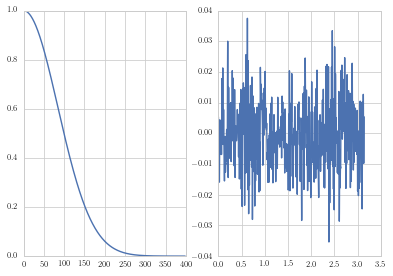

In [15]:
ncoeff = A.shape[0]
s2 = .09
mu = 0.0
spec = (np.exp(-(np.linspace(0, 1, A.shape[0])-mu)**2/s2))
coeffs = np.random.randn(ncoeff) *np.sqrt(spec + spec[::-1]) #/A.max(-1)
coeffs /= np.linalg.norm(coeffs)
yy = np.dot(A.T, coeffs)
subplot(121)
plot(spec)
subplot(122)
plot(ts, yy)

# Figure 5:  Deep networks in the chaotic regime are more expressive than shallow networks. 
(A) Activity of four different neurons in the output layer as a function of the input, θ for three networks of different depth. (B) Linear regression of the output activity onto a random function (black) shows closer predictions (blue) with deeper networks (bottom) than shallow networks (top). (C) Decompos- ing the prediction error by frequency shows shallow networks cannot capture high frequency content in the random functions but deep networks can (yellow=high error). (D) Increasing the width of a one hidden layer network up to 10,000 does not decrease error at high frequencies.


In [16]:
from cornet.viz import add_label, pcolor
def plot_basis(A, **kwargs):
    """Plot errors averaging over sine/cosine pairs"""
    return pcolor(omegas[1::2], np.arange(A.shape[0]), 0.5 * (A[:, ::2] + A[:, 1::2]),**kwargs)

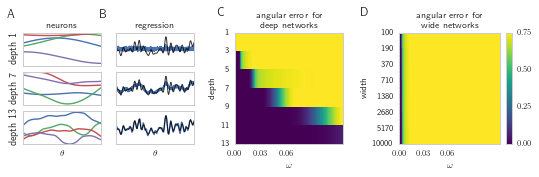

In [17]:
gs = GridSpec(3, 6, width_ratios=(2,2,.3,2.75,.7,3.2))
figure(figsize=(9, 2))
# Panel A - neuron functions
neuron_idx = [20, 30, 40, 50]
for i, didx in enumerate(didxs):
    subplot(gs[i, 0])
    plot(ts, hs_cache[i][0, :, neuron_idx].T)
    xlim(0, np.pi)
    xticks([])
    yticks([])
    if i == 0:
        title('neurons')
        add_label('A', yoff=1.7)
    if i == 2:
        xlabel(r'$\theta$')
    #if i == 1:
    ylabel('depth %d'%depths[didx], fontsize=10)
    #ylabel('a.u.')
    
    subplot(gs[i, 1])
    plot(ts, np.dot(A_net_cache[didx][:, :], coeffs))
    plot(ts, yy, lw=1, color='k', alpha=0.8)
    xlim(0, np.pi/10.)
    yticks([])
    xticks([])
    if i == 0:
        title('regression')
        add_label('B', yoff=1.7)

    elif i == 2:
        xlabel(r'$\theta$')

# Panel C - deep networks
subplot(gs[:, 3])
plot_basis(mm_net_deep[:, :, 1:].mean(1), cmap=cm.viridis, vmin=0, vmax=0.75)
axis('tight')
yticks(np.arange(len(depths)))
gca().set_yticklabels(depths)
ylabel('depth')
xlabel(r'$\omega$')
title('angular error for\ndeep networks')
xticks([0, 0.03, 0.06])
add_label('C', xoff=-.1, yoff=1.23)
plt.gca().invert_yaxis()

# Panel D - wide networks
subplot(gs[:, 5])
plot_basis(mm_net_wide[:, :, 1:].mean(1), cmap=cm.viridis, vmin=0, vmax=0.75)
axis('tight')
yticks(np.arange(len(n_hiddens)))
gca().set_yticklabels(n_hiddens)
ylabel('width')
xlabel(r'$\omega$')
title('angular error for\nwide networks')
xticks([0, 0.03, 0.06])
colorbar(ticks=[0, 0.25, 0.5, 0.75])
add_label('D', xoff=-.3, yoff=1.23)
plt.gca().invert_yaxis()

savefig(os.path.join(figure_dir, "fig5_expressivity.pdf" ), bbox_inches='tight')